In [24]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (accuracy_score, precision_score, recall_score,
                           f1_score, roc_auc_score, classification_report,
                           confusion_matrix, roc_curve)
import xgboost as xgb
import lightgbm as lgb
import warnings
warnings.filterwarnings('ignore')

In [28]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (accuracy_score, precision_score, recall_score,
                           f1_score, roc_auc_score, classification_report,
                           confusion_matrix, roc_curve)
import xgboost as xgb
import lightgbm as lgb
import warnings
warnings.filterwarnings('ignore')

class TelcoChurnPredictor:
    def __init__(self):
        self.models = {}
        self.scaler = StandardScaler()
        self.label_encoders = {}
        self.feature_names = None
        self.best_model_name = None

    def load_and_preprocess_data(self, file_path):
        """
        Load and preprocess the telco dataset
        """
        print("🔄 Loading and preprocessing data...")

        # Load data
        df = pd.read_csv(file_path)
        print(f"✅ Loaded dataset with {df.shape[0]} customers and {df.shape[1]} features")

        # Display basic information
        print(f"\nDataset Info:")
        print(f"- Shape: {df.shape}")
        print(f"- Missing values: {df.isnull().sum().sum()}")
        print(f"- Churn rate: {(df['Churn'] == 'Yes').mean():.1%}")

        # Handle TotalCharges - often stored as string with spaces
        if df['TotalCharges'].dtype == 'object':
            df['TotalCharges'] = df['TotalCharges'].str.strip()
            df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')

        # Fill missing TotalCharges with calculated value
        missing_total_charges = df['TotalCharges'].isnull()
        if missing_total_charges.sum() > 0:
            print(f"⚠️  Found {missing_total_charges.sum()} missing TotalCharges values")
            df.loc[missing_total_charges, 'TotalCharges'] = (
                df.loc[missing_total_charges, 'MonthlyCharges'] *
                df.loc[missing_total_charges, 'tenure']
            )

        # Feature Engineering - Create meaningful features
        print("🔧 Creating new features...")

        # 1. Average monthly charges (Total/Tenure)
        df['AvgMonthlyCharges'] = df['TotalCharges'] / (df['tenure'] + 1)

        # 2. Tenure groups
        df['TenureGroup'] = pd.cut(df['tenure'],
                                 bins=[0, 12, 24, 48, 72],
                                 labels=['0-1year', '1-2years', '2-4years', '4+years'])

        # 3. Total services count
        service_cols = ['PhoneService', 'MultipleLines', 'OnlineSecurity',
                       'OnlineBackup', 'DeviceProtection', 'TechSupport',
                       'StreamingTV', 'StreamingMovies']

        df['TotalServices'] = 0
        for col in service_cols:
            if col in df.columns:
                df['TotalServices'] += (df[col] == 'Yes').astype(int)

        # 4. High value customer flag
        df['HighValueCustomer'] = (df['MonthlyCharges'] > df['MonthlyCharges'].quantile(0.75)).astype(int)

        # 5. Contract risk flag (month-to-month is higher risk)
        df['ContractRisk'] = (df['Contract'] == 'Month-to-month').astype(int)

        print(f"✅ Created {5} new engineered features")

        return df

    def prepare_features(self, df):
        """
        Encode categorical variables and prepare features for ML models
        """
        print("🔄 Preparing features for ML models...")

        # Separate features and target
        X = df.drop(['customerID', 'Churn'], axis=1)
        y = df['Churn'].map({'Yes': 1, 'No': 0})

        # Identify categorical and numerical columns
        categorical_cols = X.select_dtypes(include=['object', 'category']).columns.tolist()
        numerical_cols = X.select_dtypes(include=['int64', 'float64']).columns.tolist()

        print(f"📊 Categorical features: {len(categorical_cols)}")
        print(f"📊 Numerical features: {len(numerical_cols)}")

        # Encode categorical variables
        X_encoded = X.copy()
        for col in categorical_cols:
            le = LabelEncoder()
            X_encoded[col] = le.fit_transform(X[col].astype(str))
            self.label_encoders[col] = le

        self.feature_names = X_encoded.columns.tolist()

        return X_encoded, y

    def split_data(self, X, y, test_size=0.2, random_state=42):
        """
        Split data into training and testing sets
        """
        print("🔪 Splitting data into train/test sets...")

        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=test_size, random_state=random_state, stratify=y
        )

        print(f"✅ Train set: {X_train.shape[0]} customers ({y_train.mean():.1%} churn)")
        print(f"✅ Test set: {X_test.shape[0]} customers ({y_test.mean():.1%} churn)")

        return X_train, X_test, y_train, y_test

    def train_models(self, X_train, y_train):
        """
        Train multiple ML models for churn prediction
        """
        print("\n🤖 Training ML Models...")

        # 1. Baseline: Logistic Regression
        print("Training Logistic Regression (Baseline)...")
        X_train_scaled = self.scaler.fit_transform(X_train)

        lr_model = LogisticRegression(random_state=42, max_iter=1000)
        lr_model.fit(X_train_scaled, y_train)
        self.models['Logistic Regression'] = {
            'model': lr_model,
            'requires_scaling': True
        }

        # 2. Random Forest
        print("Training Random Forest...")
        rf_model = RandomForestClassifier(
            n_estimators=100,
            max_depth=15,
            min_samples_split=10,
            min_samples_leaf=4,
            random_state=42,
            n_jobs=-1
        )
        rf_model.fit(X_train, y_train)
        self.models['Random Forest'] = {
            'model': rf_model,
            'requires_scaling': False
        }

        # 3. XGBoost (Optimized for churn prediction)
        print("Training XGBoost...")
        xgb_model = xgb.XGBClassifier(
            n_estimators=150,
            max_depth=6,
            learning_rate=0.1,
            subsample=0.8,
            colsample_bytree=0.8,
            min_child_weight=3,
            gamma=0.1,
            random_state=42,
            eval_metric='logloss'
        )
        xgb_model.fit(X_train, y_train)
        self.models['XGBoost'] = {
            'model': xgb_model,
            'requires_scaling': False
        }

        # 4. LightGBM
        print("Training LightGBM...")
        lgb_model = lgb.LGBMClassifier(
            n_estimators=150,
            max_depth=6,
            learning_rate=0.1,
            subsample=0.8,
            colsample_bytree=0.8,
            min_child_samples=20,
            reg_alpha=0.1,
            reg_lambda=0.1,
            random_state=42,
            verbose=-1
        )
        lgb_model.fit(X_train, y_train)
        self.models['LightGBM'] = {
            'model': lgb_model,
            'requires_scaling': False
        }

        print("✅ All models trained successfully!")

    def evaluate_models(self, X_test, y_test):
        """
        Evaluate all trained models with comprehensive metrics
        """
        print("\n📊 Evaluating Model Performance...")
        print("="*60)

        results = {}

        for name, model_info in self.models.items():
            model = model_info['model']
            requires_scaling = model_info['requires_scaling']

            # Prepare test data
            if requires_scaling:
                X_test_processed = self.scaler.transform(X_test)
            else:
                X_test_processed = X_test

            # Make predictions
            y_pred = model.predict(X_test_processed)
            y_pred_proba = model.predict_proba(X_test_processed)[:, 1]

            # Calculate metrics
            accuracy = accuracy_score(y_test, y_pred)
            precision = precision_score(y_test, y_pred)
            recall = recall_score(y_test, y_pred)
            f1 = f1_score(y_test, y_pred)
            roc_auc = roc_auc_score(y_test, y_pred_proba)

            results[name] = {
                'accuracy': accuracy,
                'precision': precision,
                'recall': recall,
                'f1_score': f1,
                'roc_auc': roc_auc,
                'y_pred': y_pred,
                'y_pred_proba': y_pred_proba
            }

            # Print results
            print(f"\n{name}:")
            print(f"  Accuracy:  {accuracy:.4f}")
            print(f"  Precision: {precision:.4f}")
            print(f"  Recall:    {recall:.4f}")
            print(f"  F1-Score:  {f1:.4f}")
            print(f"  ROC-AUC:   {roc_auc:.4f} ⭐")

        # Find best model based on ROC-AUC
        self.best_model_name = max(results.keys(), key=lambda x: results[x]['roc_auc'])
        print(f"\n🏆 Best Model: {self.best_model_name} (ROC-AUC: {results[self.best_model_name]['roc_auc']:.4f})")

        return results

    def plot_model_comparison(self, results):
        """
        Visualize model performance comparison
        """
        # Create comparison dataframe
        metrics_df = pd.DataFrame(results).T

        fig, axes = plt.subplots(2, 2, figsize=(15, 10))
        fig.suptitle('Model Performance Comparison', fontsize=16, fontweight='bold')

        # ROC-AUC (most important for churn)
        axes[0,0].bar(metrics_df.index, metrics_df['roc_auc'], color='skyblue')
        axes[0,0].set_title('ROC-AUC (Higher is Better)')
        axes[0,0].set_ylabel('ROC-AUC Score')
        axes[0,0].tick_params(axis='x', rotation=45)
        axes[0,0].set_ylim(0, 1)

        # Accuracy
        axes[0,1].bar(metrics_df.index, metrics_df['accuracy'], color='lightgreen')
        axes[0,1].set_title('Accuracy')
        axes[0,1].set_ylabel('Accuracy')
        axes[0,1].tick_params(axis='x', rotation=45)
        axes[0,1].set_ylim(0, 1)

        # Precision vs Recall
        axes[1,0].scatter(metrics_df['recall'], metrics_df['precision'], s=150, alpha=0.7)
        for i, model in enumerate(metrics_df.index):
            axes[1,0].annotate(model, (metrics_df['recall'].iloc[i], metrics_df['precision'].iloc[i]),
                             xytext=(5, 5), textcoords='offset points', fontsize=9)
        axes[1,0].set_xlabel('Recall')
        axes[1,0].set_ylabel('Precision')
        axes[1,0].set_title('Precision vs Recall')
        axes[1,0].grid(True, alpha=0.3)

        # F1-Score
        axes[1,1].bar(metrics_df.index, metrics_df['f1_score'], color='coral')
        axes[1,1].set_title('F1-Score')
        axes[1,1].set_ylabel('F1-Score')
        axes[1,1].tick_params(axis='x', rotation=45)
        axes[1,1].set_ylim(0, 1)

        plt.tight_layout()
        plt.show()

        return metrics_df

    def plot_roc_curves(self, results, y_test):
        """
        Plot ROC curves for all models
        """
        plt.figure(figsize=(10, 8))

        colors = ['blue', 'red', 'green', 'orange']

        for i, (name, result) in enumerate(results.items()):
            fpr, tpr, _ = roc_curve(y_test, result['y_pred_proba'])
            plt.plot(fpr, tpr, label=f"{name} (AUC = {result['roc_auc']:.3f})",
                    color=colors[i % len(colors)], linewidth=2)

        plt.plot([0, 1], [0, 1], 'k--', alpha=0.5, label='Random Classifier')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('ROC Curves - Churn Prediction Models')
        plt.legend()
        plt.grid(True, alpha=0.3)
        plt.show()

    def analyze_feature_importance(self, model_name=None):
        """
        Analyze and plot feature importance for tree-based models
        """
        if not model_name:
            model_name = self.best_model_name

        if model_name not in self.models:
            print(f"Model {model_name} not found!")
            return

        model = self.models[model_name]['model']

        if hasattr(model, 'feature_importances_'):
            # Create importance dataframe
            importance_df = pd.DataFrame({
                'feature': self.feature_names,
                'importance': model.feature_importances_
            }).sort_values('importance', ascending=False)

            print(f"\n🔍 Top 10 Most Important Features ({model_name}):")
            print("-" * 50)
            for i, row in importance_df.head(10).iterrows():
                print(f"{row['feature']:25s}: {row['importance']:.4f}")

            # Plot feature importance
            plt.figure(figsize=(12, 8))
            top_features = importance_df.head(15)
            sns.barplot(data=top_features, y='feature', x='importance', palette='viridis')
            plt.title(f'{model_name} - Feature Importance (Top 15)')
            plt.xlabel('Importance Score')
            plt.tight_layout()
            plt.show()

            return importance_df
        else:
            print(f"Model {model_name} doesn't support feature importance")

    def plot_confusion_matrix(self, results, y_test):
        """
        Plot confusion matrix for the best model
        """
        best_result = results[self.best_model_name]
        cm = confusion_matrix(y_test, best_result['y_pred'])

        plt.figure(figsize=(8, 6))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                   xticklabels=['No Churn', 'Churn'],
                   yticklabels=['No Churn', 'Churn'])
        plt.title(f'Confusion Matrix - {self.best_model_name}')
        plt.ylabel('Actual')
        plt.xlabel('Predicted')
        plt.show()

        # Calculate business metrics
        tn, fp, fn, tp = cm.ravel()
        print(f"\n📈 Business Impact Analysis ({self.best_model_name}):")
        print(f"True Negatives (Correctly identified loyal customers): {tn}")
        print(f"False Positives (Incorrectly flagged as churners): {fp}")
        print(f"False Negatives (Missed churners): {fn}")
        print(f"True Positives (Correctly identified churners): {tp}")

        # Customer retention metrics
        total_churners = tp + fn
        identified_churners = tp
        retention_opportunity = f"{(identified_churners/total_churners)*100:.1f}%"
        print(f"\n💰 Retention Opportunity: {retention_opportunity} of potential churners identified")

    def predict_churn_probability(self, customer_data):
        """
        Predict churn probability for new customers
        """
        if not self.best_model_name:
            print("❌ No model trained yet!")
            return None

        model_info = self.models[self.best_model_name]
        model = model_info['model']

        # Encode categorical features for the new customer
        customer_encoded = customer_data.copy()
        for col, encoder in self.label_encoders.items():
            if col in customer_encoded:
                try:
                    customer_encoded[col] = encoder.transform([str(customer_encoded[col])])[0]
                except:
                    # Handle unseen categories
                    customer_encoded[col] = 0

        # Ensure all features are present
        for feature in self.feature_names:
            if feature not in customer_encoded:
                customer_encoded[feature] = 0

        # Reorder features to match training
        customer_array = np.array([customer_encoded[feature] for feature in self.feature_names]).reshape(1, -1)

        # Scale if required
        if model_info['requires_scaling']:
            customer_array = self.scaler.transform(customer_array)

        # Make prediction
        churn_probability = model.predict_proba(customer_array)[0][1]
        churn_prediction = "High Risk 🔴" if churn_probability > 0.5 else "Low Risk 🟢"

        return {
            'churn_probability': churn_probability,
            'risk_level': churn_prediction,
            'confidence': f"{churn_probability:.1%}",
            'model_used': self.best_model_name
        }

    def generate_churn_insights(self, df, results):
        """
        Generate business insights from the churn analysis
        """
        print("\n" + "="*60)
        print("              CHURN PREDICTION INSIGHTS")
        print("="*60)

        # Churn analysis by key factors
        churn_by_contract = df.groupby('Contract')['Churn'].apply(lambda x: (x == 'Yes').mean())
        churn_by_payment = df.groupby('PaymentMethod')['Churn'].apply(lambda x: (x == 'Yes').mean())
        churn_by_internet = df.groupby('InternetService')['Churn'].apply(lambda x: (x == 'Yes').mean())

        print("\n📊 Churn Rate Analysis:")
        print(f"\n1. By Contract Type:")
        for contract, rate in churn_by_contract.items():
            print(f"   {contract:20s}: {rate:.1%}")

        print(f"\n2. By Payment Method:")
        for payment, rate in churn_by_payment.items():
            print(f"   {payment:25s}: {rate:.1%}")

        print(f"\n3. By Internet Service:")
        for internet, rate in churn_by_internet.items():
            print(f"   {internet:15s}: {rate:.1%}")

        # High-risk customer segments
        high_risk_segments = []

        if churn_by_contract['Month-to-month'] > 0.3:
            high_risk_segments.append("Month-to-month contract customers")

        if 'Electronic check' in churn_by_payment and churn_by_payment['Electronic check'] > 0.3:
            high_risk_segments.append("Electronic check payment customers")

        print(f"\n🚨 High-Risk Customer Segments:")
        for i, segment in enumerate(high_risk_segments, 1):
            print(f"   {i}. {segment}")

        print(f"\n💡 Model Recommendations:")
        print(f"   • Focus retention efforts on: {high_risk_segments[0] if high_risk_segments else 'Month-to-month customers'}")
        print(f"   • Best model for deployment: {self.best_model_name}")
        print(f"   • Model accuracy: {results[self.best_model_name]['roc_auc']:.1%}")

def run_telco_churn_prediction(file_path):
    """
    Complete end-to-end churn prediction pipeline
    """
    # Initialize predictor
    predictor = TelcoChurnPredictor()

    # Step 1: Load and preprocess data
    df = predictor.load_and_preprocess_data(file_path)

    # Step 2: Prepare features
    X, y = predictor.prepare_features(df)

    # Step 3: Split data
    X_train, X_test, y_train, y_test = predictor.split_data(X, y)

    # Step 4: Train models
    predictor.train_models(X_train, y_train)

    # Step 5: Evaluate models
    results = predictor.evaluate_models(X_test, y_test)

    # Step 6: Visualizations
    metrics_df = predictor.plot_model_comparison(results)
    predictor.plot_roc_curves(results, y_test)
    predictor.plot_confusion_matrix(results, y_test)

    # Step 7: Feature importance analysis
    importance_df = predictor.analyze_feature_importance()

    # Step 8: Business insights
    predictor.generate_churn_insights(df, results)

    return predictor, results, df

# Example usage for prediction
def predict_customer_churn_example(predictor):
    """
    Example of how to predict churn for new customers
    """
    print("\n" + "="*60)
    print("              CHURN PREDICTION EXAMPLE")
    print("="*60)

    # Example customer profiles
    customers = [
        {
            'gender': 'Female',
            'SeniorCitizen': 0,
            'Partner': 'Yes',
            'Dependents': 'No',
            'tenure': 2,
            'PhoneService': 'Yes',
            'MultipleLines': 'No',
            'InternetService': 'Fiber optic',
            'OnlineSecurity': 'No',
            'OnlineBackup': 'No',
            'DeviceProtection': 'No',
            'TechSupport': 'No',
            'StreamingTV': 'Yes',
            'StreamingMovies': 'Yes',
            'Contract': 'Month-to-month',
            'PaperlessBilling': 'Yes',
            'PaymentMethod': 'Electronic check',
            'MonthlyCharges': 95.0,
            'TotalCharges': 190.0,
            'TenureGroup': '0-1year',
            'TotalServices': 2,
            'HighValueCustomer': 1,
            'ContractRisk': 1,
            'AvgMonthlyCharges': 95.0
        },
        {
            'gender': 'Male',
            'SeniorCitizen': 0,
            'Partner': 'Yes',
            'Dependents': 'Yes',
            'tenure': 45,
            'PhoneService': 'Yes',
            'MultipleLines': 'Yes',
            'InternetService': 'DSL',
            'OnlineSecurity': 'Yes',
            'OnlineBackup': 'Yes',
            'DeviceProtection': 'Yes',
            'TechSupport': 'Yes',
            'StreamingTV': 'No',
            'StreamingMovies': 'No',
            'Contract': 'Two year',
            'PaperlessBilling': 'No',
            'PaymentMethod': 'Bank transfer (automatic)',
            'MonthlyCharges': 65.0,
            'TotalCharges': 2925.0,
            'TenureGroup': '2-4years',
            'TotalServices': 6,
            'HighValueCustomer': 0,
            'ContractRisk': 0,
            'AvgMonthlyCharges': 65.0
        }
    ]

    for i, customer in enumerate(customers, 1):
        print(f"\n👤 Customer {i} Profile:")
        print(f"   Contract: {customer['Contract']}")
        print(f"   Tenure: {customer['tenure']} months")
        print(f"   Monthly Charges: ${customer['MonthlyCharges']}")
        print(f"   Internet Service: {customer['InternetService']}")
        print(f"   Payment Method: {customer['PaymentMethod']}")

        result = predictor.predict_churn_probability(customer)
        if result:
            print(f"\n🎯 Prediction Result:")
            print(f"   Churn Risk: {result['risk_level']}")
            print(f"   Probability: {result['confidence']}")
            print(f"   Model: {result['model_used']}")

# Main execution
if __name__ == "__main__":
    print("🚀 TELCO CUSTOMER CHURN PREDICTION SYSTEM")
    print("="*60)

    # Instructions for running with your data
    print("\n📁 To run with your dataset:")
    print("1. Save your CSV file (e.g., 'telco_churn.csv')")
    print("2. Update the file path below")
    print("3. Run the pipeline")

    print("\n💡 Usage Example:")
    print("""
    # Load and run prediction pipeline
    file_path = 'your_telco_churn_dataset.csv'  # Update this path
    predictor, results, df = run_telco_churn_prediction(file_path)

    # Make predictions for new customers
    predict_customer_churn_example(predictor)
    """)

    # Sample execution with synthetic data (for demonstration)
    print("\n🔄 Creating sample data for demonstration...")

    # Create sample dataset matching your column structure
    np.random.seed(42)
    n_samples = 2000

    sample_data = {
        'customerID': [f'C{i:05d}' for i in range(n_samples)],
        'gender': np.random.choice(['Male', 'Female'], n_samples),
        'SeniorCitizen': np.random.choice([0, 1], n_samples, p=[0.84, 0.16]),
        'Partner': np.random.choice(['Yes', 'No'], n_samples),
        'Dependents': np.random.choice(['Yes', 'No'], n_samples, p=[0.7, 0.3]),
        'tenure': np.random.randint(1, 73, n_samples),
        'PhoneService': np.random.choice(['Yes', 'No'], n_samples, p=[0.9, 0.1]),
        'MultipleLines': np.random.choice(['Yes', 'No', 'No phone service'], n_samples, p=[0.4, 0.5, 0.1]),
        'InternetService': np.random.choice(['DSL', 'Fiber optic', 'No'], n_samples, p=[0.34, 0.44, 0.22]),
        'OnlineSecurity': np.random.choice(['Yes', 'No', 'No internet service'], n_samples, p=[0.28, 0.5, 0.22]),
        'OnlineBackup': np.random.choice(['Yes', 'No', 'No internet service'], n_samples, p=[0.34, 0.44, 0.22]),
        'DeviceProtection': np.random.choice(['Yes', 'No', 'No internet service'], n_samples, p=[0.34, 0.44, 0.22]),
        'TechSupport': np.random.choice(['Yes', 'No', 'No internet service'], n_samples, p=[0.29, 0.49, 0.22]),
        'StreamingTV': np.random.choice(['Yes', 'No', 'No internet service'], n_samples, p=[0.38, 0.4, 0.22]),
        'StreamingMovies': np.random.choice(['Yes', 'No', 'No internet service'], n_samples, p=[0.39, 0.39, 0.22]),
        'Contract': np.random.choice(['Month-to-month', 'One year', 'Two year'], n_samples, p=[0.55, 0.21, 0.24]),
        'PaperlessBilling': np.random.choice(['Yes', 'No'], n_samples, p=[0.59, 0.41]),
        'PaymentMethod': np.random.choice(['Electronic check', 'Mailed check', 'Bank transfer (automatic)', 'Credit card (automatic)'],
                                        n_samples, p=[0.34, 0.23, 0.22, 0.21])
    }

    sample_df = pd.DataFrame(sample_data)

    # Generate realistic charges
    sample_df['MonthlyCharges'] = np.random.uniform(18.25, 118.75, n_samples)
    sample_df.loc[sample_df['InternetService'] == 'Fiber optic', 'MonthlyCharges'] *= 1.2
    sample_df['TotalCharges'] = sample_df['MonthlyCharges'] * sample_df['tenure']

🚀 TELCO CUSTOMER CHURN PREDICTION SYSTEM

📁 To run with your dataset:
1. Save your CSV file (e.g., 'telco_churn.csv')
2. Update the file path below
3. Run the pipeline

💡 Usage Example:

    # Load and run prediction pipeline
    file_path = 'your_telco_churn_dataset.csv'  # Update this path
    predictor, results, df = run_telco_churn_prediction(file_path)
    
    # Make predictions for new customers
    predict_customer_churn_example(predictor)
    

🔄 Creating sample data for demonstration...


🔄 Loading and preprocessing data...
✅ Loaded dataset with 7043 customers and 21 features

Dataset Info:
- Shape: (7043, 21)
- Missing values: 0
- Churn rate: 26.5%
⚠️  Found 11 missing TotalCharges values
🔧 Creating new features...
✅ Created 5 new engineered features
🔄 Preparing features for ML models...
📊 Categorical features: 16
📊 Numerical features: 8
🔪 Splitting data into train/test sets...
✅ Train set: 5634 customers (26.5% churn)
✅ Test set: 1409 customers (26.5% churn)

🤖 Training ML Models...
Training Logistic Regression (Baseline)...
Training Random Forest...
Training XGBoost...
Training LightGBM...
✅ All models trained successfully!

📊 Evaluating Model Performance...

Logistic Regression:
  Accuracy:  0.8020
  Precision: 0.6578
  Recall:    0.5294
  F1-Score:  0.5867
  ROC-AUC:   0.8451 ⭐

Random Forest:
  Accuracy:  0.7878
  Precision: 0.6307
  Recall:    0.4840
  F1-Score:  0.5477
  ROC-AUC:   0.8339 ⭐

XGBoost:
  Accuracy:  0.7935
  Precision: 0.6343
  Recall:    0.5241
  

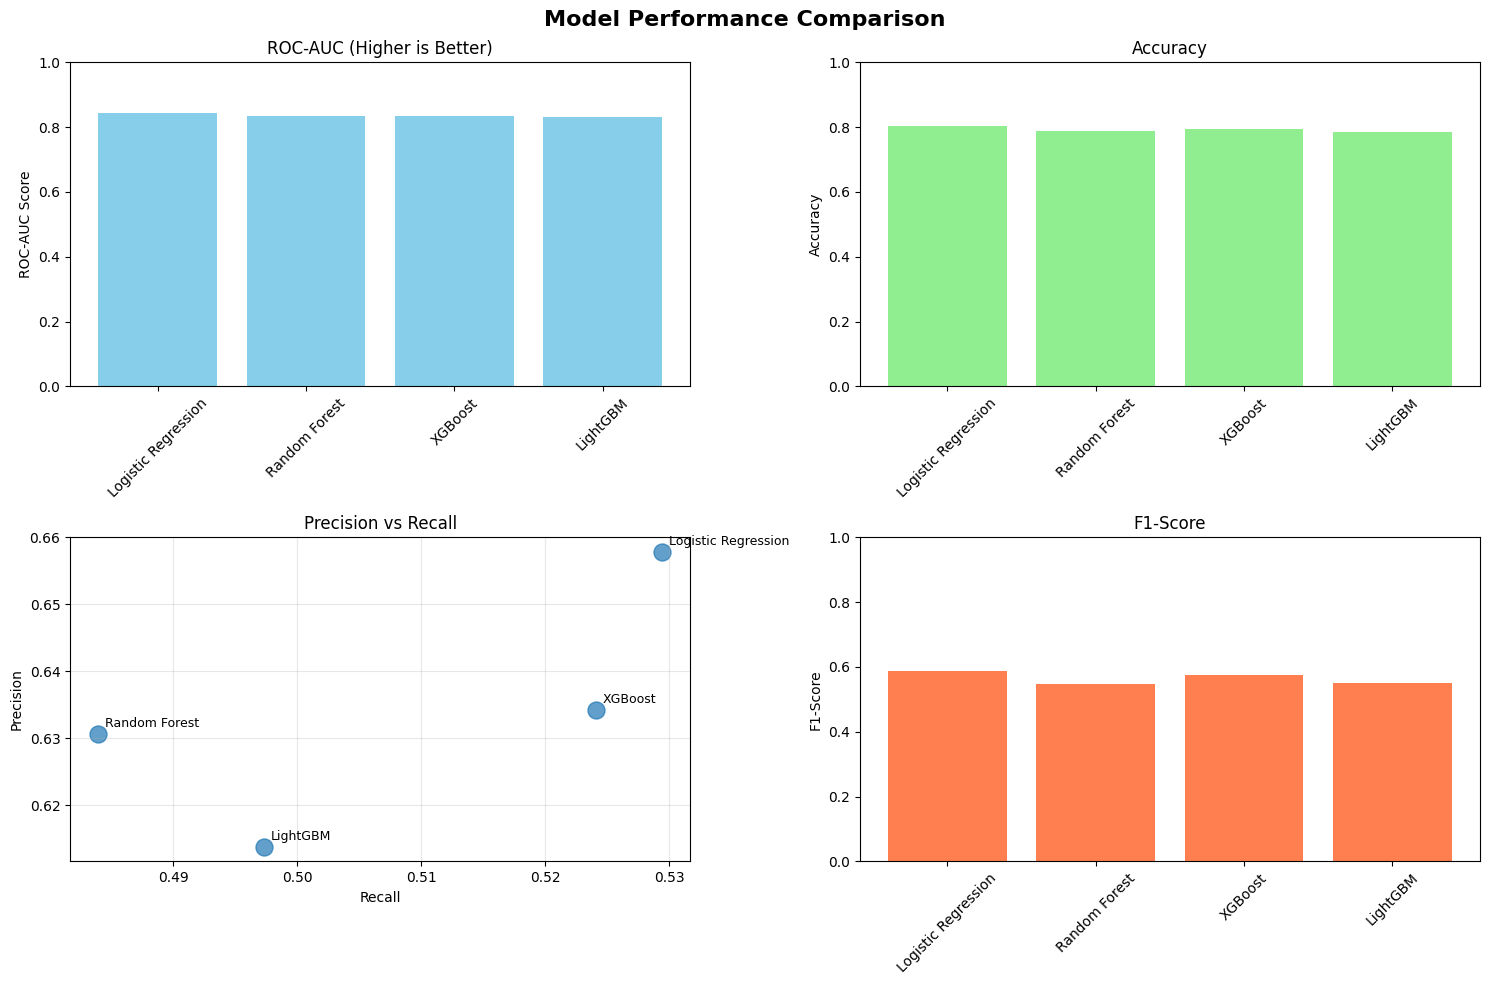

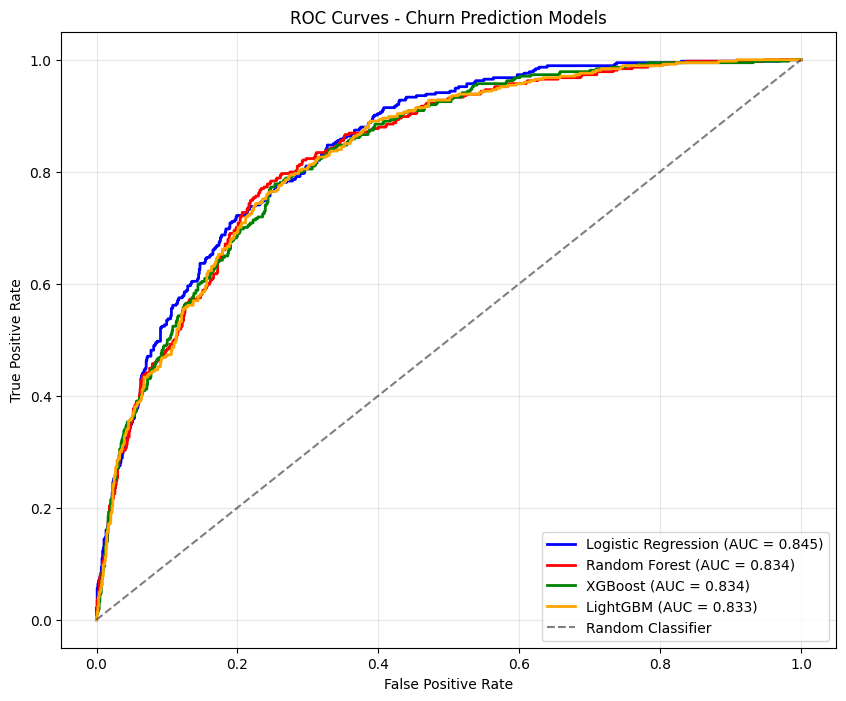

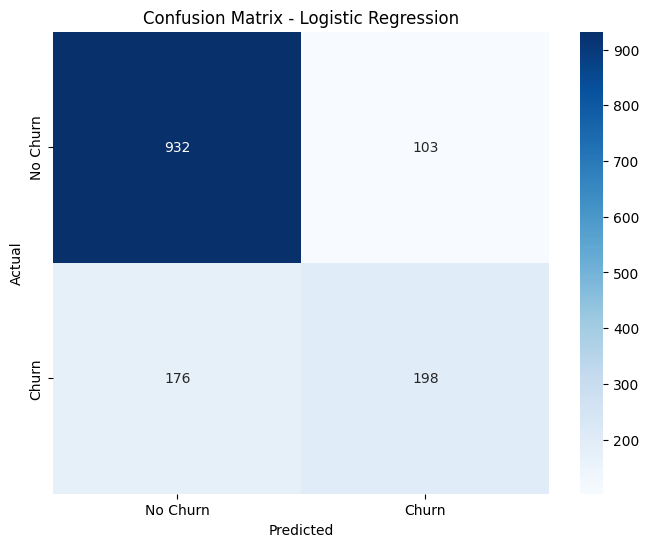


📈 Business Impact Analysis (Logistic Regression):
True Negatives (Correctly identified loyal customers): 932
False Positives (Incorrectly flagged as churners): 103
False Negatives (Missed churners): 176
True Positives (Correctly identified churners): 198

💰 Retention Opportunity: 52.9% of potential churners identified
Model Logistic Regression doesn't support feature importance

              CHURN PREDICTION INSIGHTS

📊 Churn Rate Analysis:

1. By Contract Type:
   Month-to-month      : 42.7%
   One year            : 11.3%
   Two year            : 2.8%

2. By Payment Method:
   Bank transfer (automatic): 16.7%
   Credit card (automatic)  : 15.2%
   Electronic check         : 45.3%
   Mailed check             : 19.1%

3. By Internet Service:
   DSL            : 19.0%
   Fiber optic    : 41.9%
   No             : 7.4%

🚨 High-Risk Customer Segments:
   1. Month-to-month contract customers
   2. Electronic check payment customers

💡 Model Recommendations:
   • Focus retention efforts on

In [29]:
predictor, results, df = run_telco_churn_prediction('churn_data.csv')